# False Positive Brand Classifier - EDA & Feature Engineering

## Project Context

This notebook is part of an **ESG News Monitoring System** that tracks sustainability trends for 50 sportswear and outdoor apparel brands. The system:

1. **Collects news articles daily** from NewsData.io and GDELT APIs using brand-specific keyword queries
2. **Filters false positives** using this classifier (e.g., "Puma" the animal vs Puma sportswear)
3. **Classifies ESG content** using a pre-filter classifier to identify articles with sustainability relevance
4. **Labels articles** with specific ESG categories using Claude LLM:
   - **Environmental**: Carbon emissions, waste management, sustainable materials
   - **Social**: Worker rights, diversity & inclusion, community engagement
   - **Governance**: Ethical sourcing, transparency, board structure
   - **Digital Transformation**: Technology innovation, digital initiatives

**Pipeline Position:** Data Collection → **FP Filter (this classifier)** → EP Filter → LLM Labeling

This FP classifier is the **first filter in the pipeline**, reducing LLM API costs by removing articles that don't actually discuss the sportswear brands we're tracking.

---

## Target Brands (50)

| | | | | |
|-------|-------|-------|-------|-------|
| Nike | Adidas | Puma | Under Armour | Lululemon |
| Patagonia | Columbia Sportswear | New Balance | ASICS | Reebok |
| Skechers | Fila | The North Face | Vans | Converse |
| Salomon | Mammut | Umbro | Anta | Li-Ning |
| Brooks Running | Decathlon | Deckers | Yonex | Mizuno |
| K-Swiss | Altra Running | Hoka | Saucony | Merrell |
| Timberland | Spyder | On Running | Allbirds | Gymshark |
| Everlast | Arc'teryx | Jack Wolfskin | Athleta | Vuori |
| Cotopaxi | Prana | Eddie Bauer | 361 Degrees | Xtep |
| Peak Sport | Mountain Hardwear | Black Diamond | Outdoor Voices | Diadora |

See `src/data_collection/config.py` for the authoritative brand list.

---

## Notebook Objective

Develop a feature engineering pipeline that distinguishes articles genuinely discussing sportswear brands from **false positives**. False positives include:

1. **Brand name conflicts** - "Puma" the animal, "Patagonia" the region, "Black Diamond" the power company
2. **Tangential mentions** - Articles about other companies that briefly mention a sportswear brand

See the [False Positive Definition](#false-positive-definition) section for detailed examples.

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - downstream LLM can catch it

We optimize for **F2 score** which weights recall 2x higher than precision.

---

## Technical Approach

### Data Split Strategy
| Split | Percentage | Purpose |
|-------|------------|---------|
| Training | 60% | Fit feature transformers, train classifiers |
| Validation | 20% | Feature engineering comparison via CV |
| Test | 20% | Reserved for fp3 final evaluation |

### Feature Engineering Methods Compared

#### TF-IDF + LSA Methods
| Method | Description | Features |
|--------|-------------|----------|
| `tfidf_lsa_ner_proximity` | TF-IDF + LSA + NER + proximity to sportswear vocabulary | ~120 |
| `tfidf_lsa_ner_proximity_brands` | + Brand-specific context features (frequency, position) | ~175 |

#### Sentence Transformer Methods
| Method | Description | Features |
|--------|-------------|----------|
| `sentence_transformer_ner` | `all-MiniLM-L6-v2` embeddings (384-dim) + NER features | ~398 |
| `sentence_transformer_ner_brands` | + Brand-specific context features | ~451 |

### Key Feature Types
- **Semantic features**: TF-IDF term patterns + LSA dimensionality reduction; Sentence transformers for dense contextual embeddings
- **NER features**: spaCy entity counts (ORG, GPE, PERSON, PRODUCT) to distinguish company news from geographic/biographical content
- **Proximity features**: Distance between brand mentions and sportswear vocabulary (e.g., "running", "athletic", "sneaker")
- **Brand context features**: Brand mention frequency, position (title vs body), co-occurrence with sportswear terms

### Evaluation Methodology
- **Cross-validation**: 3-fold stratified CV on train+val combined (80% of data)
- **Primary Metric**: F2 score (weights recall 2x over precision)
- **Baseline Classifiers**: Logistic Regression, Random Forest, HistGradientBoosting
- **Hyperparameter Tuning**: Grid search over key transformer parameters (e.g., LSA components)

### Artifacts Produced
| Artifact | Description |
|----------|-------------|
| `fp_feature_transformer.joblib` | Fitted feature transformer for fp2/fp3 |
| `fp_feature_config.json` | Transformer configuration for reproducibility |
| `fp_fe_comparison.json` | Cross-validation results for all methods |

---

## Contents

1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis-all-data) - Class distribution before splitting
4. [Data Preprocessing & Split](#3-data-preprocessing--trainvaltest-split) - Text cleaning and stratified split
5. [Exploratory Data Analysis](#4-exploratory-data-analysis-training-data-only) - Text length, brand distribution, word frequencies
6. [Feature Engineering Comparison](#5-feature-engineering-comparison) - Cross-validation comparison of methods
   - [Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning) - Tune best method's parameters
7. [Pipeline Export](#6-pipeline-export) - Save transformer for model selection notebook
8. [Summary](#7-summary)

## False Positive Definition

A "false positive" in this context means an article that was captured by our data collection pipeline (because it mentions a sportswear brand name) but should NOT be labeled with ESG categories. There are two distinct types:

### 1. Brand Name Conflicts
The brand name in the article refers to something other than the sportswear company:
- **Puma** → the animal (wildcat/cougar), Ford Puma (car), or Puma Exploration (mining company)
- **Patagonia** → the geographic region in South America
- **Columbia** → the country, Columbia River, Columbia University, or Columbia Pictures
- **North Face** → geographic term for the north side of a mountain
- **Black Diamond** → Black Diamond Corporation (power company) or Black Diamond Therapeutics
- **Vans** → vehicles (delivery vans, camper vans, electric van fleets)
- **Anta** → political district in India, or Antalpha Platform (NASDAQ: ANTA - financial company)
- **Decathlon** → Decathlon Capital Partners (venture capital firm)

### 2. Tangential Brand Mentions
The brand name correctly refers to the sportswear company, but the article is not primarily ABOUT that brand:
- **Biographical mentions** - "Former Nike VP joins Battery Company as CEO" (article is about the battery company, not Nike)
- **Incidental references** - Articles about other companies that briefly mention a sportswear brand for comparison
- **Historical context** - News about acquisitions where the brand is mentioned only as background

**Key Test:** Is this article primarily about the sportswear brand's current activities, products, or ESG initiatives? If the brand is only mentioned as background context, historical reference, or biographical detail, it's a false positive.

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    analyze_tuning_results,
    evaluate_feature_engineering,
    plot_fe_comparison,
    plot_tuning_results,
    run_transformer_tuning,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 1,340 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 9.66 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],wwd.com,[],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],complex.com,[],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],mlive.com,[],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],abc7news.com,[],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     1340 non-null   object
 1   title          1340 non-null   object
 2   content        1340 non-null   object
 3   brands         1340 non-null   object
 4   source_name    1340 non-null   object
 5   category       1340 non-null   object
 6   is_sportswear  1340 non-null   int64 
 7   source         1340 non-null   object
 8   fp_reason      235 non-null    object
dtypes: int64(1), object(8)
memory usage: 94.3+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id          0
title               0
content             0
brands              0
source_name         0
category            0
is_sportswear       0
source              0
fp_reason        1105
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           631
skipped           462
false_positive    247
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 1,340

Class distribution:
  Not Sportswear (FP): 247 (18.4%)
  Sportswear: 1,093 (81.6%)

Imbalance ratio: 4.43:1

[OK] Dataset is reasonably balanced
Figure saved to images/fp_target_distribution.png


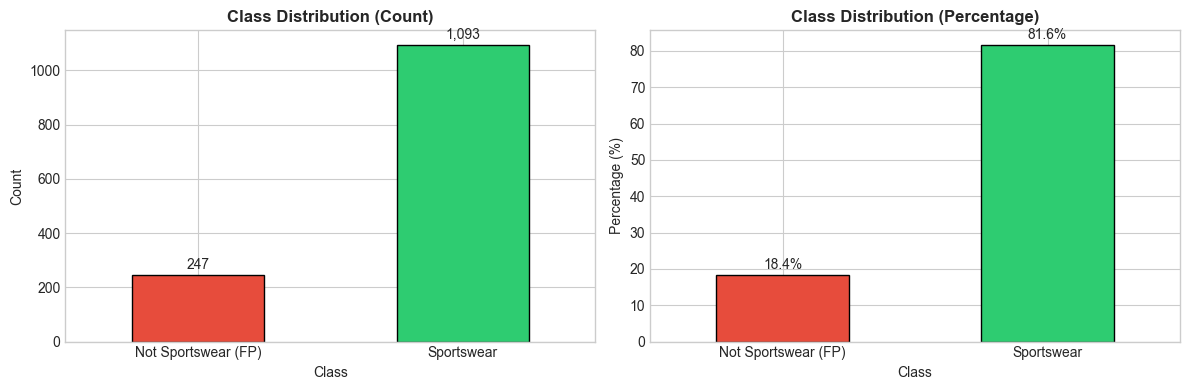

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, content, and metadata (source, category) into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL].values

X_val = val_df['text_features']
y_val = val_df[TARGET_COL].values

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

# Combine train+val for feature engineering comparison and tuning
# CV will create its own internal train/val splits, so we use 80% of data
X_trainval = pd.concat([X_train, X_val], ignore_index=True)
y_trainval = np.concatenate([y_train, y_val])
trainval_source_names = train_source_names + val_source_names
trainval_categories = train_categories + val_categories

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")
print(f"  Train+Val (for CV): {len(X_trainval)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,340

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      804 (60.0%)
  Validation: 268 (20.0%)
  Test:       268 (20.0%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 81.6%, 0: 18.4%
  Val: 1: 81.3%, 0: 18.7%
  Test: 1: 81.7%, 0: 18.3%

Dataset sizes:
  Train: 804 samples
  Val:   268 samples
  Train+Val (for CV): 1072 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 804

Overall statistics:
  Character length: mean=3700, median=2702, range=[122, 52711]
  Word count: mean=596, median=426, range=[22, 8910]

By is_sportswear:
  Class 1:
    Chars: mean=3487, median=2656
    Words: mean=564, median=426
  Class 0:
    Chars: mean=4647, median=2829
    Words: mean=741, median=426


Figure saved to images/fp_text_length_dist.png


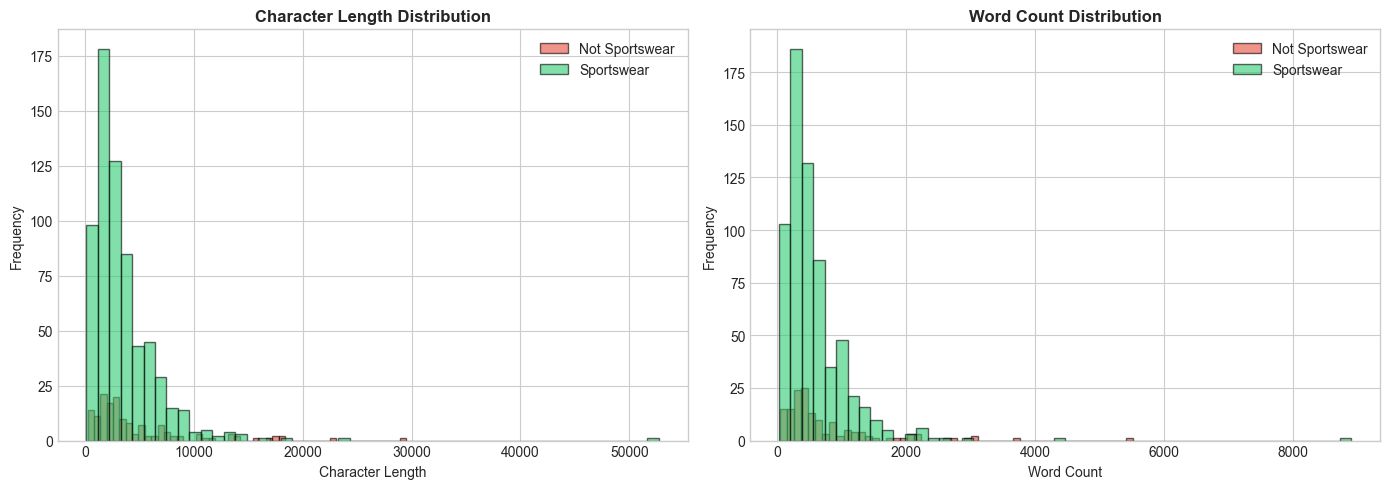

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 851
Unique brands: 44

Top 15 brands:
  Nike: 220 (25.9%)
  Lululemon: 100 (11.8%)
  Adidas: 57 (6.7%)
  Puma: 42 (4.9%)
  Hoka: 38 (4.5%)
  Vans: 33 (3.9%)
  Anta: 33 (3.9%)
  Patagonia: 31 (3.6%)
  New Balance: 30 (3.5%)
  Black Diamond: 26 (3.1%)
  Reebok: 22 (2.6%)
  Skechers: 21 (2.5%)
  Timberland: 20 (2.4%)
  ASICS: 18 (2.1%)
  Salomon: 18 (2.1%)

Brand distribution by is_sportswear:
  Class 0: 142 mentions, top: Black Diamond (24), Vans (24), Anta (22)
  Class 1: 709 mentions, top: Nike (216), Lululemon (100), Adidas (57)


Figure saved to images/fp_brand_dist.png


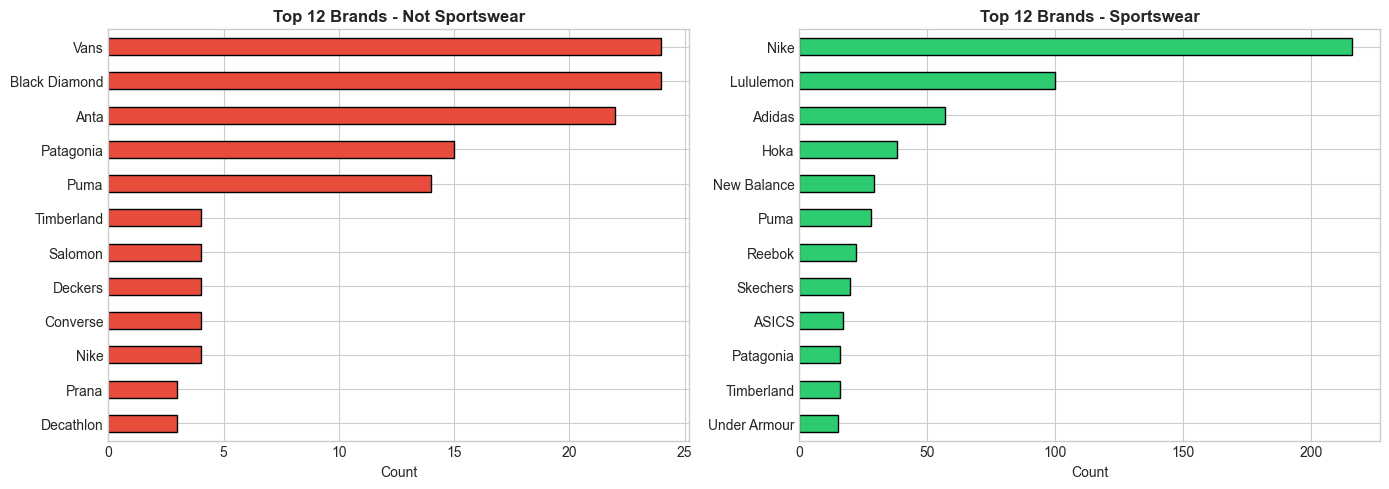

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 367
  over: 180
  year: 169
  out: 168
  get: 151
  puma: 143
  time: 142
  black: 140
  stock: 137
  like: 134
  diamond: 134
  vans: 126
  mining: 124
  report: 123
  across: 122

Top 15 words for class_1:
  nike: 2,026
  company: 1,518
  year: 1,068
  shares: 1,005
  stock: 968
  brand: 899
  lululemon: 768
  quarter: 758
  price: 712
  running: 700
  shoe: 669
  like: 664
  out: 663
  shoes: 613
  market: 561


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Puma']
Title: Puma (OTCMKTS:PMMAF) Stock Crosses Above 50 Day Moving Average – Should You Sell?...
Reason: Puma: Article is purely about stock market performance and financial analysis of Puma AG shares, with no ESG-related content about the sportswear company's activities, products, or initiatives
----------------------------------------

Brands: ['Puma']
Title: Puma Exploration Inc .: Puma Exploration Announces Increase in Kinros Equity Stake...
Reason: Puma: Article is about Puma Exploration Inc., a Canadian mineral exploration company focused on gold mining projects, not Puma the sportswear brand
----------------------------------------

Brands: ['Vans']
Title: Love Island Star Nic Vans Denver DJ Show Announced...
Reason: Vans: Article is about Nicolas Vansteenberghe, nicknamed 'Nic Vans', a Love Island reality TV star who became a DJ. The name 'Vans' refers to his surname/nickname, not Vans footwear company.
---------

## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the combined training+validation data (80% of total). Since cross-validation creates its own internal train/val splits, using the full train+val set provides more data for reliable hyperparameter selection while keeping the test set completely held out.

We benchmark with three classifiers: Logistic Regression, Random Forest, and HistGradientBoosting. This helps us select the best feature engineering approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    # 'tfidf_word': {
    #     'method': 'tfidf_word',
    #     'max_features': 10000,
    #     'ngram_range': (1, 2),
    #     'sublinear_tf': True,
    # },
    # 'tfidf_lsa': {
    #     'method': 'tfidf_lsa',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    # },
    # 'tfidf_lsa_ner': {
    #     'method': 'tfidf_lsa_ner',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'proximity_window_size': 15,
    # },
    # 'tfidf_lsa_proximity': {
    #     'method': 'tfidf_lsa_proximity',
    #     'max_features': 10000,
    #     'lsa_n_components': 100,
    #     'proximity_window_size': 15,
    # },
    'tfidf_lsa_ner_proximity': {
        'method': 'tfidf_lsa_ner_proximity',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
    },
    'tfidf_lsa_ner_proximity_brands': {
        'method': 'tfidf_lsa_ner_proximity_brands',
        'max_features': 10000,
        'lsa_n_components': 100,
        'proximity_window_size': 15,
    },
    # 'doc2vec': {
    #     'method': 'doc2vec',
    #     'doc2vec_vector_size': 100,
    #     'doc2vec_min_count': 2,
    #     'doc2vec_epochs': 40,
    #     'doc2vec_dm': 1,
    # },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
    # 'sentence_transformer_ner_proximity': {
    #     'method': 'sentence_transformer_ner_proximity',
    #     'sentence_model_name': 'all-MiniLM-L6-v2',
    #     'proximity_window_size': 15,
    # },
    'sentence_transformer_ner_brands': {
        'method': 'sentence_transformer_ner_brands',  # Fixed: was incorrectly 'sentence_transformer_ner'
        'sentence_model_name': 'all-MiniLM-L6-v2',
    }
}

# Hyperparameter tuning configurations for each method
# These define which parameter to tune and what values to try
TUNING_CONFIGS = {
    # 'tfidf_lsa': {
    #     'param_name': 'lsa_n_components',
    #     'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300],
    #     'description': 'LSA dimensionality'
    # },
    # 'tfidf_lsa_ner': {
    #     'param_name': 'lsa_n_components',
    #     'param_values': [50, 60, 80, 100, 120, 150, 200],
    #     'description': 'LSA dimensionality (with NER)'
    # },
    # 'tfidf_lsa_proximity': {
    #     'param_name': 'lsa_n_components',
    #     'param_values': [50, 60, 80, 100, 120, 150, 200],
    #     'description': 'LSA dimensionality (with proximity features)'
    # },
    'tfidf_lsa_ner_proximity': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300],
        'description': 'LSA dimensionality (with NER + proximity)'
    },
    'tfidf_lsa_ner_proximity_brands': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300],
        'description': 'LSA dimensionality (with NER + proximity + brands)'
    },
    # 'doc2vec': {
    #     'param_name': 'doc2vec_vector_size',
    #     'param_values': [50, 60, 80, 100, 120, 150],
    #     'description': 'Doc2Vec embedding dimension'
    # },
    'sentence_transformer_ner': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size'
    },
    # 'sentence_transformer_ner_proximity': {
    #     'param_name': 'proximity_window_size',
    #     'param_values': [10, 15, 20, 25, 30],
    #     'description': 'Proximity window size (uses corporate/outdoor vocab)'
    # },
    'sentence_transformer_ner_brands': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size (with brands)'
    },
    # 'tfidf_word': {
    #     'param_name': 'max_features',
    #     'param_values': [5000, 6000, 8000, 10000, 12000, 15000],
    #     'description': 'TF-IDF vocabulary size'
    # },
}

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'requires_dense': False,  # RF handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

print("\nTuning configurations defined for:")
for name in TUNING_CONFIGS:
    cfg = TUNING_CONFIGS[name]
    print(f"  {name}: {cfg['param_name']} = {cfg['param_values']}")

Feature Engineering Approaches to Compare:
  tfidf_lsa_ner_proximity: tfidf_lsa_ner_proximity
  tfidf_lsa_ner_proximity_brands: tfidf_lsa_ner_proximity_brands
  sentence_transformer_ner: sentence_transformer_ner
  sentence_transformer_ner_brands: sentence_transformer_ner_brands

Tuning configurations defined for:
  tfidf_lsa_ner_proximity: lsa_n_components = [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]
  tfidf_lsa_ner_proximity_brands: lsa_n_components = [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]
  sentence_transformer_ner: proximity_window_size = [10, 15, 20, 25, 30]
  sentence_transformer_ner_brands: proximity_window_size = [10, 15, 20, 25, 30]


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Transformer is fitted on TRAINING data only (to prevent data leakage)
# CV is performed on TRAIN+VAL combined (CV creates internal splits)
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Run feature engineering evaluation
fe_results = evaluate_feature_engineering(
    fe_configs=fe_configs,
    classifiers=classifiers,
    transformer_class=FPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    train_source_names=train_source_names,
    train_categories=train_categories,
    trainval_source_names=trainval_source_names,
    trainval_categories=trainval_categories,
    random_state=RANDOM_STATE,
)

Evaluating tfidf_lsa_ner_proximity...
  Feature shape: (1072, 142), sparse: False
  [LogisticRegression] CV F2: 0.9573 (+/- 0.0113)
  [RandomForest] CV F2: 0.9708 (+/- 0.0099)
  [HistGradientBoosting] CV F2: 0.9683 (+/- 0.0083)
Evaluating tfidf_lsa_ner_proximity_brands...
  Feature shape: (1072, 192), sparse: False
  [LogisticRegression] CV F2: 0.9620 (+/- 0.0091)
  [RandomForest] CV F2: 0.9776 (+/- 0.0044)
  [HistGradientBoosting] CV F2: 0.9681 (+/- 0.0066)
Evaluating sentence_transformer_ner...
  Feature shape: (1072, 406), sparse: False
  [LogisticRegression] CV F2: 0.9669 (+/- 0.0041)
  [RandomForest] CV F2: 0.9712 (+/- 0.0040)
  [HistGradientBoosting] CV F2: 0.9567 (+/- 0.0118)
Evaluating sentence_transformer_ner_brands...
  Feature shape: (1072, 456), sparse: False
  [LogisticRegression] CV F2: 0.9549 (+/- 0.0064)
  [RandomForest] CV F2: 0.9732 (+/- 0.0051)
  [HistGradientBoosting] CV F2: 0.9576 (+/- 0.0122)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                 n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                                          
sentence_transformer_ner                406  0.966872   0.004147   0.974827   
tfidf_lsa_ner_proximity_brands          192  0.961999   0.009095   0.962258   
tfidf_lsa_ner_proximity                 142  0.957286   0.011328   0.964549   
sentence_transformer_ner_brands         456  0.954900   0.006419   0.954232   

                                 cv_precision  
name                                           
sentence_transformer_ner             0.936573  
tfidf_lsa_ner_proximity_brands       0.961315  
tfidf_lsa_ner_proximity              0.929495  
sentence_transformer_ner_brands      0.957706  

RandomForest Results:
                                 n_features     cv_f2  cv_f2_std  cv_recall  \
name                                                              

Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fe_comparison.png


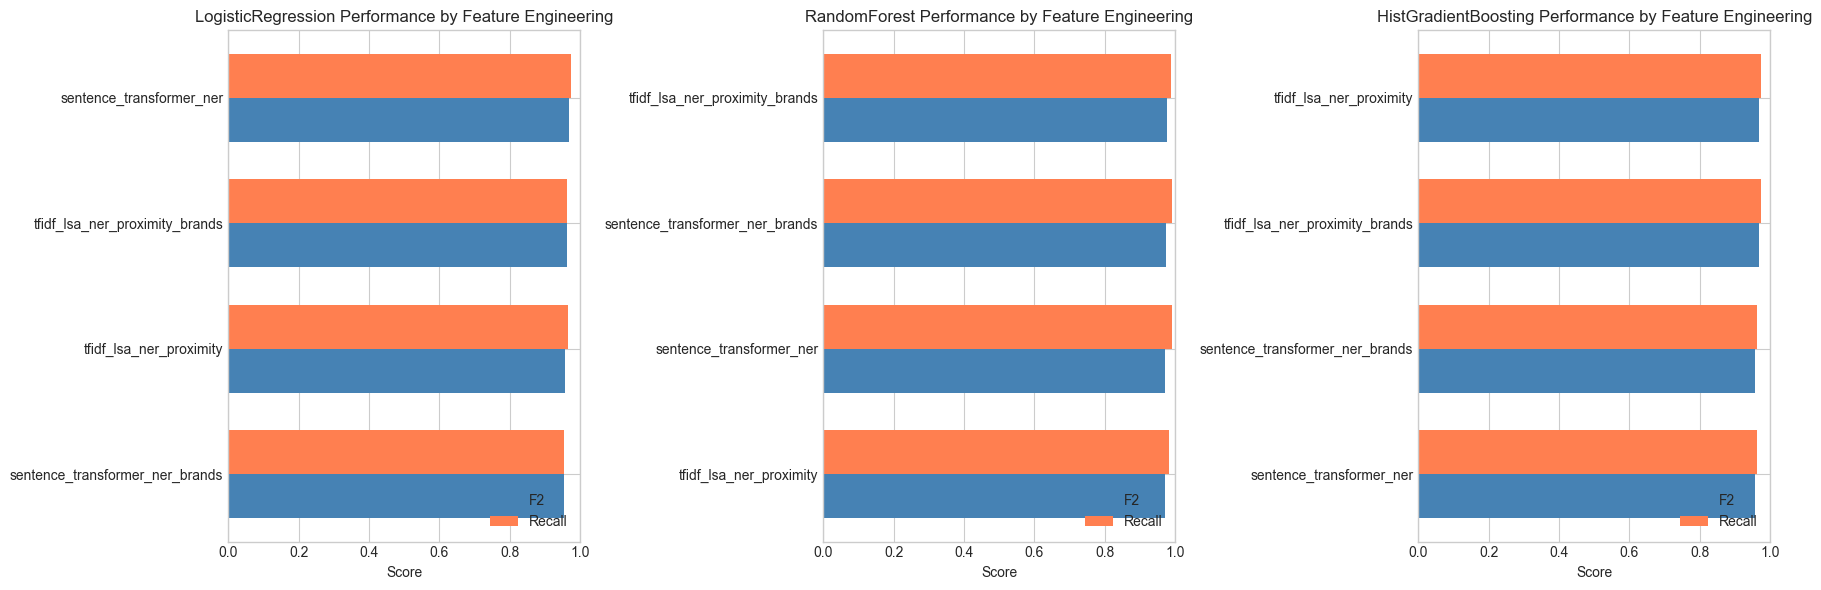

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method. Each method has a primary hyperparameter that affects its feature representation quality.

TUNING LSA_N_COMPONENTS FOR tfidf_lsa_ner_proximity_brands

Testing values: [50, 60, 70, 80, 90, 100, 120, 150, 200, 250, 300]
Classifier: RandomForest (baseline)
Transformer fitted on: TRAINING data only (804 samples)
CV evaluated on: TRAIN+VAL combined (1072 samples)
CV: 3-fold stratified

Testing lsa_n_components=50...
  CV F2: 0.9746 (+/- 0.0045)
Testing lsa_n_components=60...
  CV F2: 0.9755 (+/- 0.0035)
Testing lsa_n_components=70...
  CV F2: 0.9748 (+/- 0.0065)
Testing lsa_n_components=80...
  CV F2: 0.9755 (+/- 0.0039)
Testing lsa_n_components=90...
  CV F2: 0.9746 (+/- 0.0045)
Testing lsa_n_components=100...
  CV F2: 0.9776 (+/- 0.0044)
Testing lsa_n_components=120...
  CV F2: 0.9724 (+/- 0.0090)
Testing lsa_n_components=150...
  CV F2: 0.9751 (+/- 0.0042)
Testing lsa_n_components=200...
  CV F2: 0.9768 (+/- 0.0070)
Testing lsa_n_components=250...
  CV F2: 0.9756 (+/- 0.0077)
Testing lsa_n_components=300...
  CV F2: 0.9757 (+/- 0.0078)

LSA_N_COMPONENTS TUNING RESULTS
 lsa_n_c

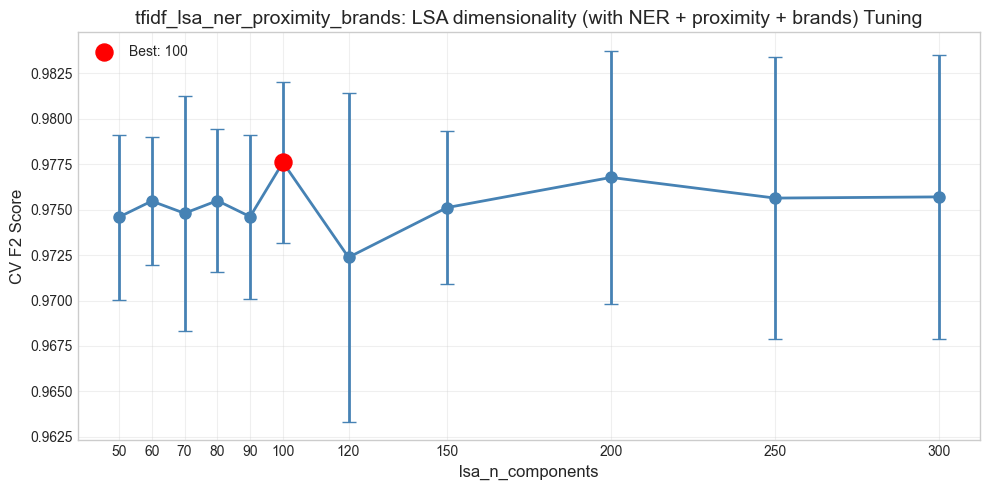

In [20]:
# Run hyperparameter tuning for the best feature transformer
tuning_df, optimal_param_value, best_tuned_f2 = run_transformer_tuning(
    best_fe=best_fe,
    best_clf=best_clf,
    fe_configs=fe_configs,
    tuning_configs=TUNING_CONFIGS,
    classifiers=classifiers,
    transformer_class=FPFeatureTransformer,
    X_train=X_train,
    X_trainval=X_trainval,
    y_trainval=y_trainval,
    cv=cv,
    scorer=f2_scorer,
    images_dir=IMAGES_DIR,
    train_source_names=train_source_names,
    train_categories=train_categories,
    trainval_source_names=trainval_source_names,
    trainval_categories=trainval_categories,
    random_state=RANDOM_STATE,
    n_folds=N_FOLDS,
)

## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [21]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = fe_configs[best_fe].copy()
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration INCLUDING tuned hyperparameters
final_transformer = FPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on TRAINING data only to avoid data leakage
# (validation and test sets should only be transformed, never used for fitting)
X_train_final = final_transformer.fit_transform(
    X_train,
    source_names=train_source_names,
    categories=train_categories
)
print(f"\nFinal feature shape: {X_train_final.shape}")
print(f"Metadata features enabled: {final_transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {final_transformer._metadata_scaler is not None}")

# Verify transformer works on validation data
X_val_final = final_transformer.transform(
    X_val,
    source_names=val_source_names,
    categories=val_categories
)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: tfidf_lsa_ner_proximity_brands
Base configuration: {'method': 'tfidf_lsa_ner_proximity_brands', 'max_features': 10000, 'lsa_n_components': 100, 'proximity_window_size': 15}
Optimal lsa_n_components: 100

Final feature shape: (804, 192)
Metadata features enabled: True
Metadata scaler fitted: True
Validation feature shape: (268, 192)


In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [23]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Train+Val (used for CV): {len(X_trainval)} ({len(X_trainval)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")

# Report best results - use tuned values if tuning was performed
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")

# Use tuned score and feature count if tuning was done, otherwise use baseline
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    print(f"  - CV F2 Score: {best_tuned_f2:.4f} (after tuning)")
    print(f"  - Features: {X_train_final.shape[1]}")
    print(f"  - Optimal {param_name}: {optimal_param_value}")
else:
    print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
    print(f"  - Features: {int(best_row['n_features'])}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'} (fitted on training data only)")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 1340 articles
  - Training: 804 (60.0%)
  - Validation: 268 (20.0%)
  - Train+Val (used for CV): 1072 (80.0%)

Class distribution (training):
  - Sportswear: 656 (81.6%)
  - False Positive: 148 (18.4%)

Best Feature Engineering: tfidf_lsa_ner_proximity_brands
  - Best Classifier: RandomForest
  - CV F2 Score: 0.9776 (after tuning)
  - Features: 192
  - Optimal lsa_n_components: 100

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib (fitted on training data only)
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
